In [1]:
import numpy as np
from simulation.generate_path import generate_path
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
# from matplotlib.animation import FFMpegWriter
from mpl_toolkits.mplot3d import Axes3D
from estimation.distance_sensor import distance_sensors
from estimation.iterative_estimator import iterative_estimator
from estimation.non_iterative_estimator import non_iterative_estimator
from estimation.kalman_filter_from_points import kalman_filter_from_points
from estimation.kalman_filter_from_points_with_acc import kalman_filter_from_points_acc
from estimation.improved_kalman_filter_from_points_with_acc import improved_kalman_filter_from_points_acc
from estimation.KF_with_mahalanobis_threshold import kalman_filter_with_mahalanobis

# For making the plots interactive, uncomment next line:
# %matplotlib widget

/home/user/miniconda3/envs/cuda_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


70731


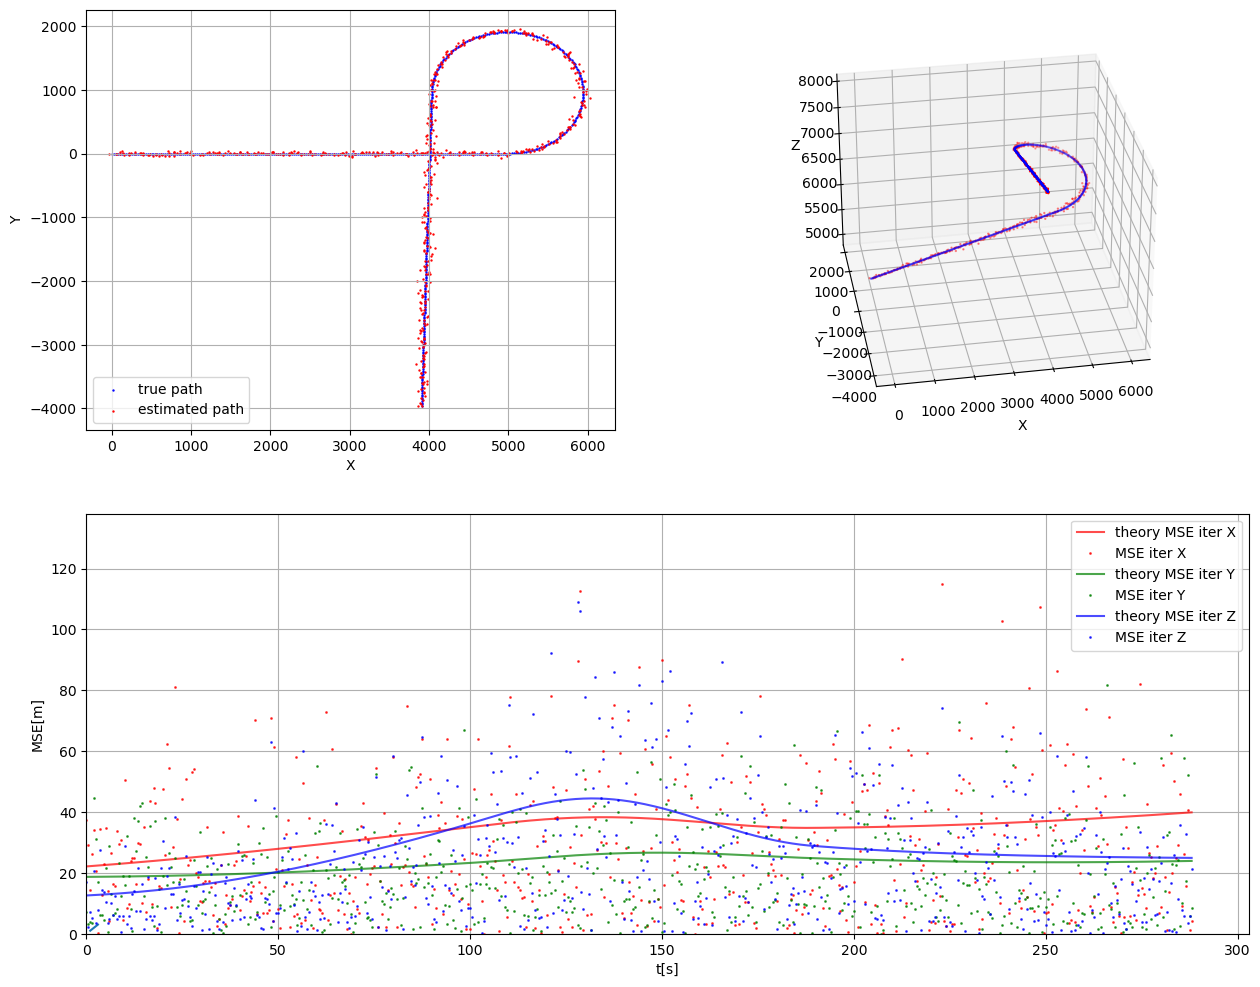

In [2]:
# animate iterative alone no outliers (with error for all 3 axis)

# print the seed used
seed = np.random.randint(0, 100000)
print(seed)
np.random.seed(seed)


target_initial_pos = np.array([0, 0, 5000])
target_speed_xy = 50
target_speed_z = 10
target_rot_speed = 3
time_res = 0.5
sensor_sigma = 15
outlier_percentage = 2
outlier_sigma=500

path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
path1.add_straight_interval(100)
path1.add_xy_turn_interval(90, -np.deg2rad(target_rot_speed))
path1.add_straight_interval(100)


# create sensors
sensors = distance_sensors([[-5000,0,0], [400, -7400, 0], [800, 800, 0]], sensor_sigma)
sensors.calculate_measurements(path1.path)

# create it estimation
it_est = iterative_estimator(sensors, path1.path[0,:])
estimated_path = it_est.estimate_path()
cov_mat_it = it_est.get_cov_err_with_sigma(estimated_path, sigma=15)

# calculate estimation error
estimation_error_iter = np.square(estimated_path-path1.path)
MSE_it_est = np.sqrt(estimation_error_iter)
cov_mat_it = it_est.get_cov_err(path1.path)
cov_MSE_it = np.sqrt(cov_mat_it * np.square(sensors.sigma))


# Plot the estimated path
fig = plt.figure(figsize = (15, 12))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 1, 2)

# ax1.view_init(elev=90, azim=-90)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

# ax1.set_zlabel('Z')
ax2.view_init(elev=30, azim=-100)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax1.set_xlim(-320.6927054038352, 6340.4673080683215)
ax1.set_ylim(-4333.051973557142, 2257.785593505313)
# ax1.set_zlim(4849.209464744964, 8066.7025598466425)
ax2.set_xlim(-320.6927054038352, 6340.4673080683215)
ax2.set_ylim(-4333.051973557142, 2257.785593505313)
ax2.set_zlim(4849.209464744964, 8066.7025598466425)


l1_1 = ax1.scatter([], [], color='blue', s=0.5, label=f'true path')
l1_2 = ax1.scatter([], [], color='red', s=0.5, label=f'estimated path')
ax1.legend(loc='lower left')
ax1.grid()

l2_1 = ax2.scatter([], [], [], color='blue', s=0.5)
l2_2 = ax2.scatter([], [], [], color='red', s=0.5)

l3_1 = ax3.plot([], [], label=f'theory MSE iter X', color='r', alpha=0.7)
l3_2 = ax3.plot([], [], label=f'MSE iter X', marker='o', linestyle='', markersize=1, color='r', alpha=0.7)
l3_3 = ax3.plot([], [], label=f'theory MSE iter Y', color='g', alpha=0.7)
l3_4 = ax3.plot([], [], label=f'MSE iter Y', marker='o', linestyle='', markersize=1, color='g', alpha=0.7)
l3_5 = ax3.plot([], [], label=f'theory MSE iter Z', color='b', alpha=0.7)
l3_6 = ax3.plot([], [], label=f'MSE iter Z', marker='o', linestyle='', markersize=1, color='b', alpha=0.7)
ax3.set_xlabel('t[s]')
ax3.set_ylabel('MSE[m]')
ax3.grid()
ax3.legend(loc='upper right')
ax3.set_xlim(0, 302.925)
ax3.set_ylim(0, 138.03753416544248)


ax3.plot([1,2,3], [1,2,3])

metadata = dict(title='iterative estimator', artist='a')
writer = PillowWriter(fps=30)

with writer.saving(fig, "animations/iterative_estimator.gif", 200):

    t = path1.time

    for i in range(0, len(t)):

        l1_1.remove()
        l1_2.remove()
        l2_1.remove()
        l2_2.remove()
    
        l1_1 = ax1.scatter(path1.path[:i, 0], path1.path[:i, 1], color='blue', s=0.5, label=f'true path',)
        l1_2 = ax1.scatter(estimated_path[:i, 0], estimated_path[:i, 1], color='red', s=0.5, label=f'estimated path',)
        l2_1 = ax2.scatter(path1.path[:i, 0], path1.path[:i, 1], path1.path[:i, 2], color='blue', s=0.5)
        l2_2 = ax2.scatter(estimated_path[:i, 0], estimated_path[:i, 1], estimated_path[:i, 2], color='red', s=0.5)


        l3_1[0].remove(); l3_1 = ax3.plot(t[:i], cov_MSE_it[:i,0], label=f'theory MSE iter X', color='r', alpha=0.7)
        l3_2[0].remove(); l3_2 = ax3.plot(t[:i], MSE_it_est[:i,0], label=f'MSE iter X', marker='o', linestyle='', markersize=1, color='r', alpha=0.7)
        l3_3[0].remove(); l3_3 = ax3.plot(t[:i], cov_MSE_it[:i,1], label=f'theory MSE iter Y', color='g', alpha=0.7)
        l3_4[0].remove(); l3_4 = ax3.plot(t[:i], MSE_it_est[:i,1], label=f'MSE iter Y', marker='o', linestyle='', markersize=1, color='g', alpha=0.7)
        l3_5[0].remove(); l3_5 = ax3.plot(t[:i], cov_MSE_it[:i,2], label=f'theory MSE iter Z', color='b', alpha=0.7)
        l3_6[0].remove(); l3_6 = ax3.plot(t[:i], MSE_it_est[:i,2], label=f'MSE iter Z', marker='o', linestyle='', markersize=1, color='b', alpha=0.7)

        writer.grab_frame()

# with writer.saving(fig, "iterative_estimator.gif", 200):
#     t = path1.time
#     for i,v in enumerate(t):
#         l1_1._offsets3d = (path1.path[:i, 0], path1.path[:i, 1], path1.path[:i, 2])
#         l1_2._offsets3d = (estimated_path[:i, 0], estimated_path[:i, 1], estimated_path[:i, 2])
#         l2_1._offsets3d = (path1.path[:i, 0], path1.path[:i, 1], path1.path[:i, 2])
#         l2_2._offsets3d = (estimated_path[:i, 0], estimated_path[:i, 1], estimated_path[:i, 2])

#         writer.grab_frame()

# ax1.scatter(path1.path[:, 0], path1.path[:, 1], path1.path[:, 2], color='blue', s=0.5)
# ax1.scatter(estimated_path[:, 0], estimated_path[:, 1], estimated_path[:, 2], color='red', s=0.5)

# ax2.scatter(path1.path[:, 0], path1.path[:, 1], path1.path[:, 2], color='blue', s=0.5)
# ax2.scatter(estimated_path[:, 0], estimated_path[:, 1], estimated_path[:, 2], color='red', s=0.5)
    

# plt.figure()
# plt.plot(t, cov_MSE_it[:,0], label=f'theory MSE iter X', color='r', alpha=0.7)
# plt.plot(t, MSE_it_est[:,0], label=f'MSE iter X', marker='o', linestyle='', markersize=1, color='r', alpha=0.7)
# plt.plot(t, cov_MSE_it[:,1], label=f'theory MSE iter Y', color='g', alpha=0.7)
# plt.plot(t, MSE_it_est[:,1], label=f'MSE iter Y', marker='o', linestyle='', markersize=1, color='g', alpha=0.7)
# plt.plot(t, cov_MSE_it[:,2], label=f'theory MSE iter Z', color='b', alpha=0.7)
# plt.plot(t, MSE_it_est[:,2], label=f'MSE iter Z', marker='o', linestyle='', markersize=1, color='b', alpha=0.7)
# plt.xlabel('t[s]')
# plt.ylabel('MSE[m]')
# plt.grid()
# plt.legend()
# plt.show()




# print(f"{ax1.get_xlim()=}")
# print(f"{ax1.get_ylim()=}")
# print(f"{ax1.get_zlim()=}")

# print(f"{ax2.get_xlim()=}")
# print(f"{ax2.get_ylim()=}")
# print(f"{ax2.get_zlim()=}")
        
# print(f"{ax3.get_xlim()=}")
# print(f"{ax3.get_ylim()=}")


69004


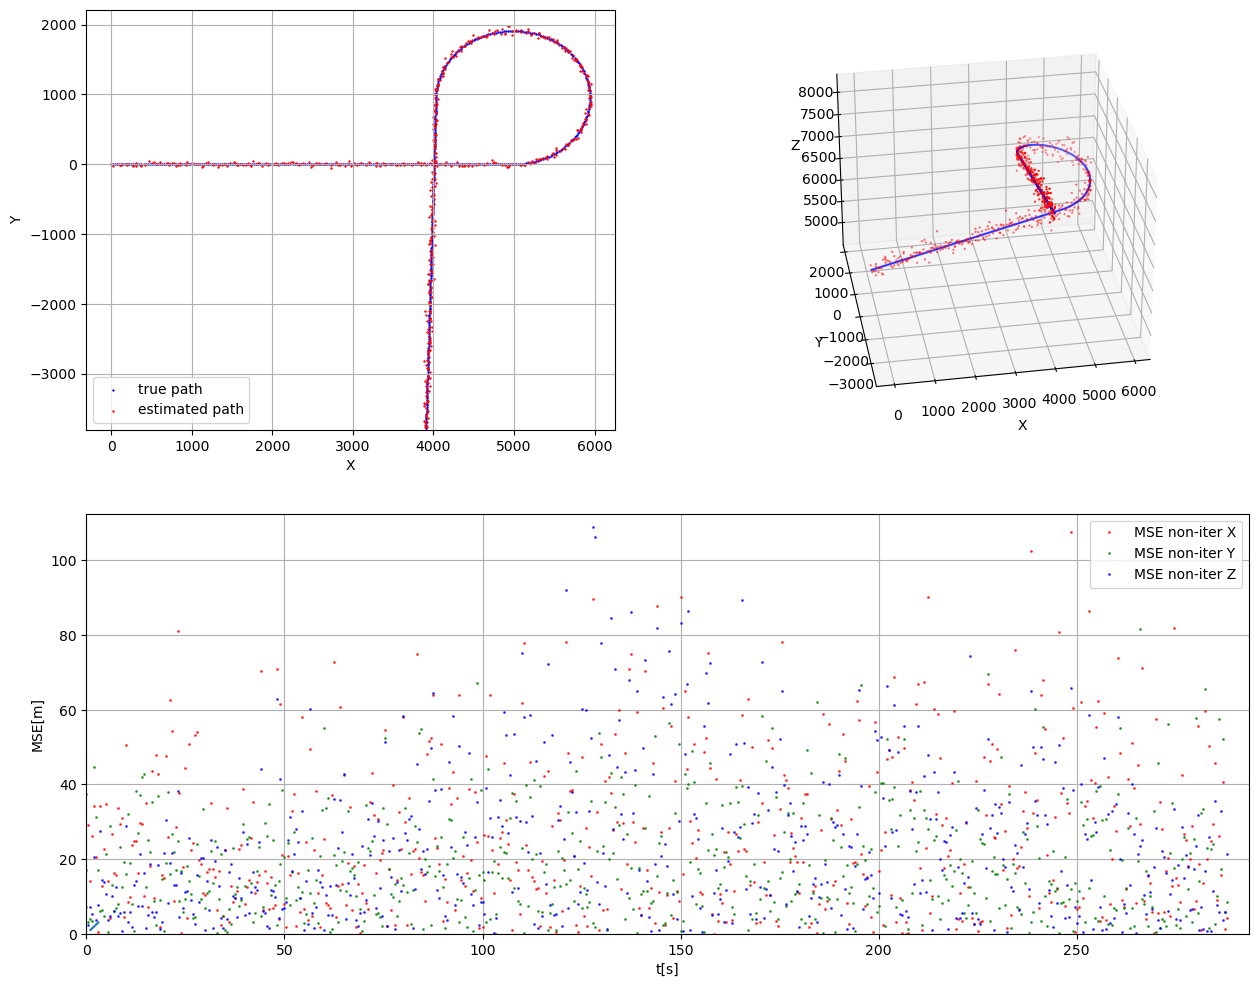

In [3]:
# animate non iterative alone no outliers (with error for all 3 axis)

# print the seed used
seed = np.random.randint(0, 100000)
print(seed)
np.random.seed(seed)

target_initial_pos = np.array([0, 0, 5000])
target_speed_xy = 50
target_speed_z = 10
target_rot_speed = 3
time_res = 0.5
sensor_sigma = 15
outlier_percentage = 2
outlier_sigma=500

path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
path1.add_straight_interval(100)
path1.add_xy_turn_interval(90, -np.deg2rad(target_rot_speed))
path1.add_straight_interval(100)

# create sensors
sensors = distance_sensors([[-5000,0,-1000],[ 400, -7400, 0],[ 800, 800, 500],[ 8000, 1000, 0]], sensor_sigma)
sensors.calculate_measurements(path1.path)

# create it estimation
non_it_est = non_iterative_estimator(sensors, path1.path[0,:])
estimated_path = non_it_est.estimate_path()

# calculate estimation error
estimation_error_iter = np.square(estimated_path-path1.path)
MSE_non_it_est = np.sqrt(estimation_error_iter)

# Plot the estimated path
fig = plt.figure(figsize = (15, 12))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 1, 2)

# ax1.view_init(elev=90, azim=-90)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
# ax1.set_zlabel('Z')
ax2.view_init(elev=30, azim=-100)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax1.set_xlim(-309.13899397680444, 6252.188891713847)
ax1.set_ylim(-3805.23525458847, 2213.6958258307727)
# ax1.set_zlim(4542.0096036363275, 8323.433543469622)
ax2.set_xlim(-309.13899397680444, 6252.188891713847)
ax2.set_ylim(-3805.23525458847, 2213.6958258307727)
ax2.set_zlim(4542.0096036363275, 8323.433543469622)


l1_1 = ax1.scatter([], [], color='blue', s=0.5, label=f'true path')
l1_2 = ax1.scatter([], [], color='red', s=0.5, label=f'estimated path')
ax1.legend(loc='lower left')
ax1.grid()

l2_1 = ax2.scatter([], [], [], color='blue', s=0.5)
l2_2 = ax2.scatter([], [], [], color='red', s=0.5)

l3_2 = ax3.plot([], [], label=f'MSE non-iter X', marker='o', linestyle='', markersize=1, color='r', alpha=0.7)
l3_4 = ax3.plot([], [], label=f'MSE non-iter Y', marker='o', linestyle='', markersize=1, color='g', alpha=0.7)
l3_6 = ax3.plot([], [], label=f'MSE non-iter Z', marker='o', linestyle='', markersize=1, color='b', alpha=0.7)
ax3.set_xlabel('t[s]')
ax3.set_ylabel('MSE[m]')
ax3.grid()
ax3.legend(loc='upper right')
ax3.set_xlim(0, 293.475)
ax3.set_ylim(0, 112.5183770039786)

ax3.plot([1,2,3], [1,2,3])

metadata = dict(title='non-iterative estimator', artist='a')
writer = PillowWriter(fps=30)

with writer.saving(fig, "animations/non_iterative_estimator.gif", 200):

    t = path1.time

    for i in range(0, len(t)):

        l1_1.remove()
        l1_2.remove()
        l2_1.remove()
        l2_2.remove()
    
        l1_1 = ax1.scatter(path1.path[:i, 0], path1.path[:i, 1], color='blue', s=0.5, label=f'true path')
        l1_2 = ax1.scatter(estimated_path[:i, 0], estimated_path[:i, 1], color='red', s=0.5, label=f'estimated path')
        l2_1 = ax2.scatter(path1.path[:i, 0], path1.path[:i, 1], path1.path[:i, 2], color='blue', s=0.5)
        l2_2 = ax2.scatter(estimated_path[:i, 0], estimated_path[:i, 1], estimated_path[:i, 2], color='red', s=0.5)


        l3_2[0].remove(); l3_2 = ax3.plot(t[:i], MSE_it_est[:i,0], label=f'MSE non-iter X', marker='o', linestyle='', markersize=1, color='r', alpha=0.7)
        l3_4[0].remove(); l3_4 = ax3.plot(t[:i], MSE_it_est[:i,1], label=f'MSE non-iter Y', marker='o', linestyle='', markersize=1, color='g', alpha=0.7)
        l3_6[0].remove(); l3_6 = ax3.plot(t[:i], MSE_it_est[:i,2], label=f'MSE non-iter Z', marker='o', linestyle='', markersize=1, color='b', alpha=0.7)

        writer.grab_frame()


# print(f"{ax1.get_xlim()=}")
# print(f"{ax1.get_ylim()=}")
# print(f"{ax1.get_zlim()=}")

# print(f"{ax2.get_xlim()=}")
# print(f"{ax2.get_ylim()=}")
# print(f"{ax2.get_zlim()=}")
        
# print(f"{ax3.get_xlim()=}")
# print(f"{ax3.get_ylim()=}")

69350


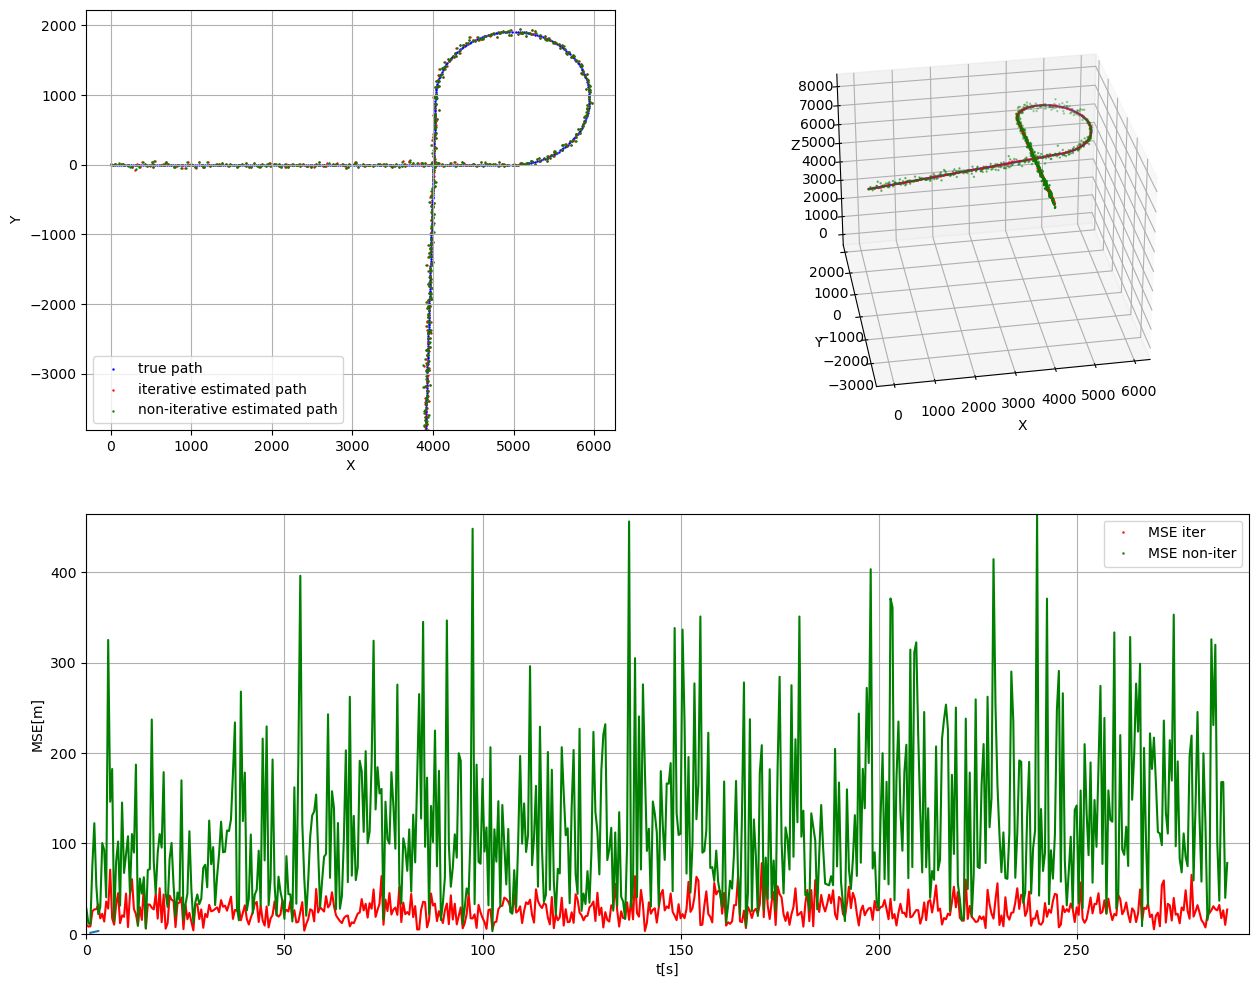

In [4]:

# animate non iterative and iterative together no outliers (with total error)

# print the seed used
seed = np.random.randint(0, 100000)
print(seed)
np.random.seed(seed)


target_initial_pos = np.array([0, 0, 5000])
target_speed_xy = 50
target_speed_z = 10
target_rot_speed = 3
time_res = 0.5
sensor_sigma = 15
outlier_percentage = 2
outlier_sigma=500

path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
path1.add_straight_interval(100)
path1.add_xy_turn_interval(90, -np.deg2rad(target_rot_speed))
path1.add_straight_interval(100)


# create sensors
sensors = distance_sensors([[-5000,0,-1000],[ 400, -7400, 0],[ 800, 800, 500],[ 8000, 1000, 0]], sensor_sigma)
sensors.calculate_measurements(path1.path)

# create it estimation
it_est = iterative_estimator(sensors, path1.path[0,:])
estimated_path_it = it_est.estimate_path()
non_it_est = non_iterative_estimator(sensors, path1.path[0,:])
estimated_path_non_it = non_it_est.estimate_path()

# calculate estimation error
MSE_it_est = np.sqrt(np.sum(np.square(estimated_path_it-path1.path), 1))
MSE_non_it_est = np.sqrt(np.sum(np.square(estimated_path_non_it-path1.path), 1))


# Plot the estimated paths
fig = plt.figure(figsize = (15, 12))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 1, 2)

# ax1.view_init(elev=90, azim=-90)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
# ax1.set_zlabel('Z')
ax2.view_init(elev=30, azim=-100)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax1.set_xlim(-300.8935504354232, 6257.180418836244)
ax1.set_ylim(-3805.206975082021, 2225.523864704389)
# ax1.set_zlim(-403.0658829940836, 8464.383542875756)
ax2.set_xlim(-300.8935504354232, 6257.180418836244)
ax2.set_ylim(-3805.206975082021, 2225.523864704389)
ax2.set_zlim(-403.0658829940836, 8464.383542875756)



l1_1 = ax1.scatter([], [], color='blue', s=0.5, label=f'true path')
l1_2 = ax1.scatter([], [], color='red', s=0.5, label=f'iterative estimated path')
l1_3 = ax1.scatter([], [], color='green', s=0.5, label=f'non-iterative estimated path')
ax1.legend(loc='lower left')
ax1.grid()


l2_1 = ax2.scatter([], [], [], color='blue', s=0.5)
l2_2 = ax2.scatter([], [], [], color='red', s=0.5)
l2_3 = ax2.scatter([], [], [], color='green', s=0.5)

l3_1 = ax3.plot([], [], label=f'MSE iter', marker='o', linestyle='', markersize=1, color='r', alpha=0.7)
l3_2 = ax3.plot([], [], label=f'MSE non-iter', marker='o', linestyle='', markersize=1, color='g', alpha=0.7)

ax3.set_xlabel('t[s]')
ax3.set_ylabel('MSE[m]')
ax3.grid()
ax3.legend(loc='upper right')
ax3.set_xlim(0, 293.475)
ax3.set_ylim(0, 464.7687868824383)

ax3.plot([1,2,3], [1,2,3])

metadata = dict(title='iter vs non-iterative estimator', artist='a')
writer = PillowWriter(fps=30)

with writer.saving(fig, "animations/iter_vs_non_iterative_estimator.gif", 200):

    t = path1.time

    for i in range(0, len(t)):

        l1_1.remove(); l1_1 = ax1.scatter(path1.path[:i, 0], path1.path[:i, 1], color='blue', s=0.5, label=f'true path')
        l1_2.remove(); l1_2 = ax1.scatter(estimated_path_it[:i, 0], estimated_path_it[:i, 1], color='red', s=0.5, label=f'iterative estimated path')
        l1_3.remove(); l1_3 = ax1.scatter(estimated_path_non_it[:i, 0], estimated_path_non_it[:i, 1], color='green', s=0.5, label=f'non-iterative estimated path')
        l2_1.remove(); l2_1 = ax2.scatter(path1.path[:i, 0], path1.path[:i, 1], path1.path[:i, 2], color='blue', s=0.5)
        l2_2.remove(); l2_2 = ax2.scatter(estimated_path_it[:i, 0], estimated_path_it[:i, 1], estimated_path_it[:i, 2], color='red', s=0.5)
        l2_3.remove(); l2_3 = ax2.scatter(estimated_path_non_it[:i, 0], estimated_path_non_it[:i, 1], estimated_path_non_it[:i, 2], color='green', s=0.5)


        l3_1[0].remove(); l3_1 = ax3.plot(t[:i], MSE_it_est[:i], label=f'MSE iter', color='r')
        l3_2[0].remove(); l3_2 = ax3.plot(t[:i], MSE_non_it_est[:i], label=f'MSE non-iter', color='g')

        writer.grab_frame()

# print(f"{ax1.get_xlim()=}")
# print(f"{ax1.get_ylim()=}")
# print(f"{ax1.get_zlim()=}")

# print(f"{ax2.get_xlim()=}")
# print(f"{ax2.get_ylim()=}")
# print(f"{ax2.get_zlim()=}")
        
# print(f"{ax3.get_xlim()=}")
# print(f"{ax3.get_ylim()=}")

58179


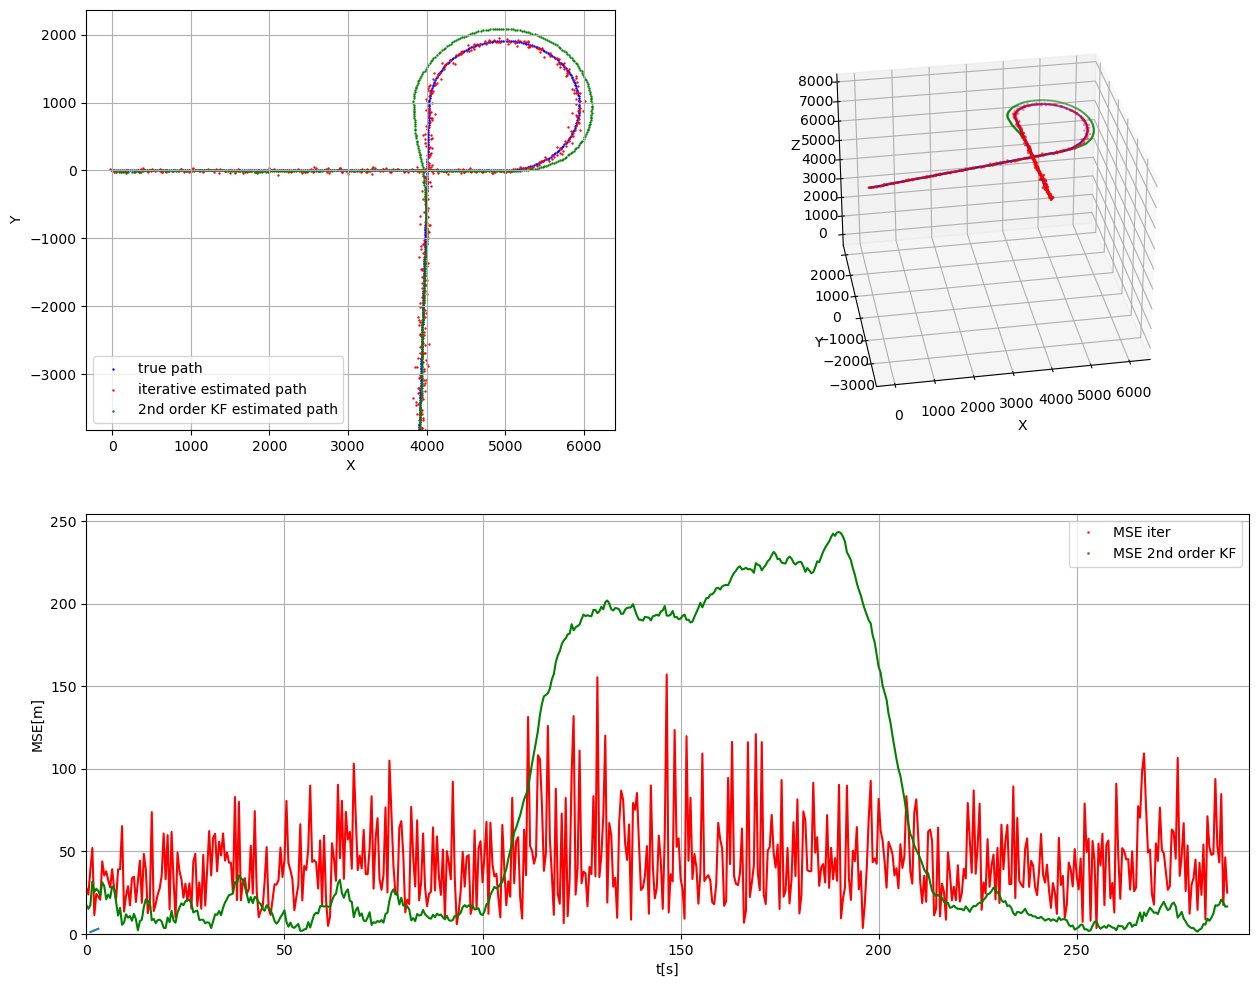

In [5]:

# animate KF second order with iterative no outliers (with total error)

# print the seed used
seed = np.random.randint(0, 100000)
print(seed)
np.random.seed(seed)


target_initial_pos = np.array([0, 0, 5000])
target_speed_xy = 50
target_speed_z = 10
target_rot_speed = 3
time_res = 0.5
sensor_sigma = 15
outlier_percentage = 2
outlier_sigma=500

path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
path1.add_straight_interval(100)
path1.add_xy_turn_interval(90, -np.deg2rad(target_rot_speed))
path1.add_straight_interval(100)

# create sensors
sensors = distance_sensors([[-5000,0,0], [400, -7400, 0], [800, 800, 0]], sensor_sigma)
sensors.calculate_measurements(path1.path)

# create it estimation
it_est = iterative_estimator(sensors, path1.path[0,:])
estimated_path_it = it_est.estimate_path()

sigma_a = 1
sigma_v = 100
kf = kalman_filter_from_points(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2, initial_P_multiplier=10000)
kf_path, _, _ = kf.filter_path(estimated_path_it)

# calculate estimation error
MSE_it_est = np.sqrt(np.sum(np.square(estimated_path_it-path1.path), 1))
MSE_kf = np.sqrt(np.sum(np.square(kf_path-path1.path), 1))

# Plot the estimated paths
fig = plt.figure(figsize = (15, 12))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 1, 2)

# ax1.view_init(elev=90, azim=-90)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
# ax1.set_zlabel('Z')
ax2.view_init(elev=30, azim=-100)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax1.set_xlim(-326.3613386912707, 6394.002072967221)
ax1.set_ylim(-3818.2816151472343, 2366.350533989159)
# ax1.set_zlim(-390.95590781955235, 8210.0740642106)
ax2.set_xlim(-326.3613386912707, 6394.002072967221)
ax2.set_ylim(-3818.2816151472343, 2366.350533989159)
ax2.set_zlim(-390.95590781955235, 8210.0740642106)


l1_1 = ax1.scatter([], [], color='blue', s=0.5, label=f'true path')
l1_2 = ax1.scatter([], [], color='red', s=0.5, label=f'iterative estimated path')
l1_3 = ax1.scatter([], [], color='green', s=0.5, label=f'2nd order KF estimated path')
ax1.legend(loc='lower left')
ax1.grid()

l2_1 = ax2.scatter([], [], [], color='blue', s=0.5)
l2_2 = ax2.scatter([], [], [], color='red', s=0.5)
l2_3 = ax2.scatter([], [], [], color='green', s=0.5)

l3_1 = ax3.plot([], [], label=f'MSE iter', marker='o', linestyle='', markersize=1, color='r', alpha=0.7)
l3_2 = ax3.plot([], [], label=f'MSE 2nd order KF', marker='o', linestyle='', markersize=1, color='g', alpha=0.7)

ax3.set_xlabel('t[s]')
ax3.set_ylabel('MSE[m]')
ax3.grid()
ax3.legend(loc='upper right')
ax3.set_xlim(0, 293.475)
ax3.set_ylim(0, 254.5433280226154)

ax3.plot([1,2,3], [1,2,3])

metadata = dict(title='iter vs 2nd order KF estimator', artist='a')
writer = PillowWriter(fps=30)

with writer.saving(fig, "animations/iter_vs_2nd_order_kf.gif", 200):

    t = path1.time

    for i in range(0, len(t)):

        l1_1.remove(); l1_1 = ax1.scatter(path1.path[:i, 0], path1.path[:i, 1], color='blue', s=0.5, label=f'true path')
        l1_2.remove(); l1_2 = ax1.scatter(estimated_path_it[:i, 0], estimated_path_it[:i, 1], color='red', s=0.5, label=f'iterative estimated path')
        l1_3.remove(); l1_3 = ax1.scatter(kf_path[:i, 0], kf_path[:i, 1], color='green', s=0.5, label=f'2nd order KF estimated path')
        l2_1.remove(); l2_1 = ax2.scatter(path1.path[:i, 0], path1.path[:i, 1], path1.path[:i, 2], color='blue', s=0.5)
        l2_2.remove(); l2_2 = ax2.scatter(estimated_path_it[:i, 0], estimated_path_it[:i, 1], estimated_path_it[:i, 2], color='red', s=0.5)
        l2_3.remove(); l2_3 = ax2.scatter(kf_path[:i, 0], kf_path[:i, 1], kf_path[:i, 2], color='green', s=0.5)


        l3_1[0].remove(); l3_1 = ax3.plot(t[:i], MSE_it_est[:i], label=f'MSE iter', color='r')
        l3_2[0].remove(); l3_2 = ax3.plot(t[:i], MSE_kf[:i], label=f'MSE 2nd order KF', color='g')

        writer.grab_frame()

# print(f"{ax1.get_xlim()=}")
# print(f"{ax1.get_ylim()=}")
# print(f"{ax1.get_zlim()=}")

# print(f"{ax2.get_xlim()=}")
# print(f"{ax2.get_ylim()=}")
# print(f"{ax2.get_zlim()=}")
        
# print(f"{ax3.get_xlim()=}")
# print(f"{ax3.get_ylim()=}")

1789


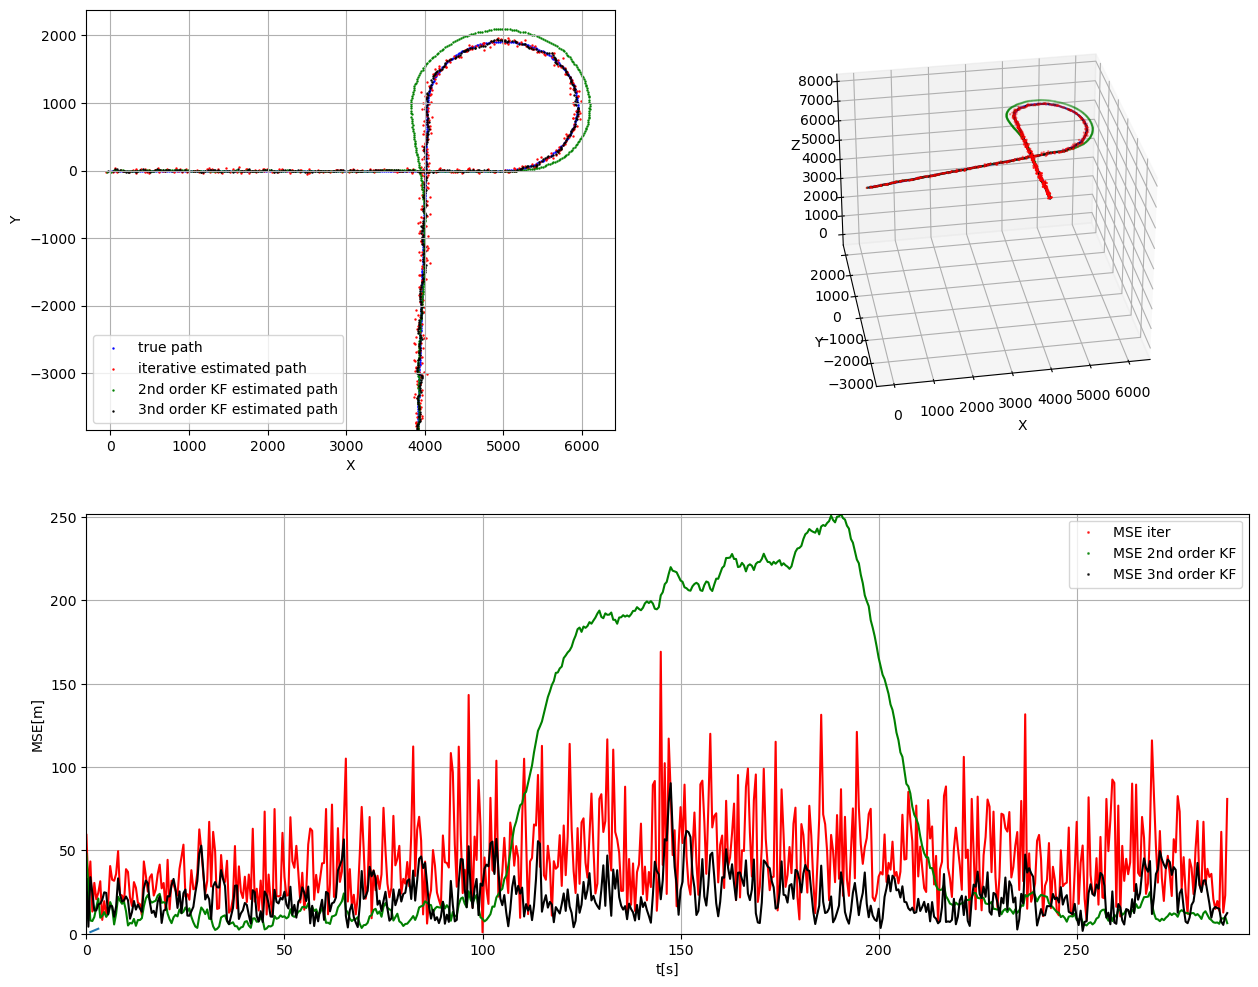

In [6]:

# animate KF third order with iterative no outliers (with total error)

# print the seed used
seed = np.random.randint(0, 100000)
print(seed)
np.random.seed(seed)


target_initial_pos = np.array([0, 0, 5000])
target_speed_xy = 50
target_speed_z = 10
target_rot_speed = 3
time_res = 0.5
sensor_sigma = 15
outlier_percentage = 2
outlier_sigma=500

path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
path1.add_straight_interval(100)
path1.add_xy_turn_interval(90, -np.deg2rad(target_rot_speed))
path1.add_straight_interval(100)

# create sensors
sensors = distance_sensors([[-5000,0,0], [400, -7400, 0], [800, 800, 0]], sensor_sigma)
sensors.calculate_measurements(path1.path)

# create it estimation
it_est = iterative_estimator(sensors, path1.path[0,:])
estimated_path_it = it_est.estimate_path()

sigma_a = 1
sigma_v = 100
kf = kalman_filter_from_points(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2, initial_P_multiplier=10000)
kf_path, _, _ = kf.filter_path(estimated_path_it)
kf_third = kalman_filter_from_points_acc(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2, initial_P_multiplier=10000)
kf_third_path = kf_third.filter_path(estimated_path_it)

# calculate estimation error
MSE_it_est = np.sqrt(np.sum(np.square(estimated_path_it-path1.path), 1))
MSE_kf = np.sqrt(np.sum(np.square(kf_path-path1.path), 1))
MSE_kf_third = np.sqrt(np.sum(np.square(kf_third_path-path1.path), 1))

# Plot the estimated paths
fig = plt.figure(figsize = (15, 12))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 1, 2)

# ax1.view_init(elev=90, azim=-90)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
# ax1.set_zlabel('Z')
ax2.view_init(elev=30, azim=-100)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax1.set_xlim(-305.52447373654667, 6416.01394846748)
ax1.set_ylim(-3835.506398692361, 2379.904912118961)
# ax1.set_zlim(-389.8478792881642, 8186.805465051449)
ax2.set_xlim(-305.52447373654667, 6416.01394846748)
ax2.set_ylim(-3835.506398692361, 2379.904912118961)
ax2.set_zlim(-389.8478792881642, 8186.805465051449)


l1_1 = ax1.scatter([], [], color='blue', s=0.5, label=f'true path')
l1_2 = ax1.scatter([], [], color='red', s=0.5, label=f'iterative estimated path')
l1_3 = ax1.scatter([], [], color='green', s=0.5, label=f'2nd order KF estimated path')
l1_4 = ax1.scatter([], [], color='k', s=0.5, label=f'3nd order KF estimated path')
ax1.legend(loc='lower left')
ax1.grid()

l2_1 = ax2.scatter([], [], [], color='blue', s=0.5)
l2_2 = ax2.scatter([], [], [], color='red', s=0.5)
l2_3 = ax2.scatter([], [], [], color='green', s=0.5)
l2_4 = ax2.scatter([], [], [], color='k', s=0.5)

l3_1 = ax3.plot([], [], label=f'MSE iter', marker='o', linestyle='', markersize=1, color='r', alpha=0.7)
l3_2 = ax3.plot([], [], label=f'MSE 2nd order KF', marker='o', linestyle='', markersize=1, color='g', alpha=0.7)
l3_3 = ax3.plot([], [], label=f'MSE 3nd order KF', marker='o', linestyle='', markersize=1, color='k', alpha=0.7)

ax3.set_xlabel('t[s]')
ax3.set_ylabel('MSE[m]')
ax3.grid()
ax3.legend(loc='upper right')
ax3.set_xlim(0, 293.475)
ax3.set_ylim(0, 252.03145740925723)

ax3.plot([1,2,3], [1,2,3])

metadata = dict(title='iter vs 3nd order KF estimator', artist='a')
writer = PillowWriter(fps=30)

with writer.saving(fig, "animations/iter_vs_3nd_order_kf.gif", 200):

    t = path1.time

    for i in range(0, len(t)):

        l1_1.remove(); l1_1 = ax1.scatter(path1.path[:i, 0], path1.path[:i, 1], color='blue', s=0.5, label=f'true path')
        l1_2.remove(); l1_2 = ax1.scatter(estimated_path_it[:i, 0], estimated_path_it[:i, 1], color='red', s=0.5, label=f'iterative estimated path')
        l1_3.remove(); l1_3 = ax1.scatter(kf_path[:i, 0], kf_path[:i, 1], color='green', s=0.5, label=f'2nd order KF estimated path')
        l1_4.remove(); l1_4 = ax1.scatter(kf_third_path[:i, 0], kf_third_path[:i, 1], color='k', s=0.5, label=f'2nd order KF estimated path')
        l2_1.remove(); l2_1 = ax2.scatter(path1.path[:i, 0], path1.path[:i, 1], path1.path[:i, 2], color='blue', s=0.5)
        l2_2.remove(); l2_2 = ax2.scatter(estimated_path_it[:i, 0], estimated_path_it[:i, 1], estimated_path_it[:i, 2], color='red', s=0.5)
        l2_3.remove(); l2_3 = ax2.scatter(kf_path[:i, 0], kf_path[:i, 1], kf_path[:i, 2], color='green', s=0.5)
        l2_4.remove(); l2_4 = ax2.scatter(kf_third_path[:i, 0], kf_third_path[:i, 1], kf_third_path[:i, 2], color='k', s=0.5)


        l3_1[0].remove(); l3_1 = ax3.plot(t[:i], MSE_it_est[:i], label=f'MSE iter', color='r')
        l3_2[0].remove(); l3_2 = ax3.plot(t[:i], MSE_kf[:i], label=f'MSE 2nd order KF', color='g')
        l3_3[0].remove(); l3_3 = ax3.plot(t[:i], MSE_kf_third[:i], label=f'MSE 3nd order KF', color='k')

        writer.grab_frame()

# print(f"{ax1.get_xlim()=}")
# print(f"{ax1.get_ylim()=}")
# print(f"{ax1.get_zlim()=}")

# print(f"{ax2.get_xlim()=}")
# print(f"{ax2.get_ylim()=}")
# print(f"{ax2.get_zlim()=}")
        
# print(f"{ax3.get_xlim()=}")
# print(f"{ax3.get_ylim()=}")

68072


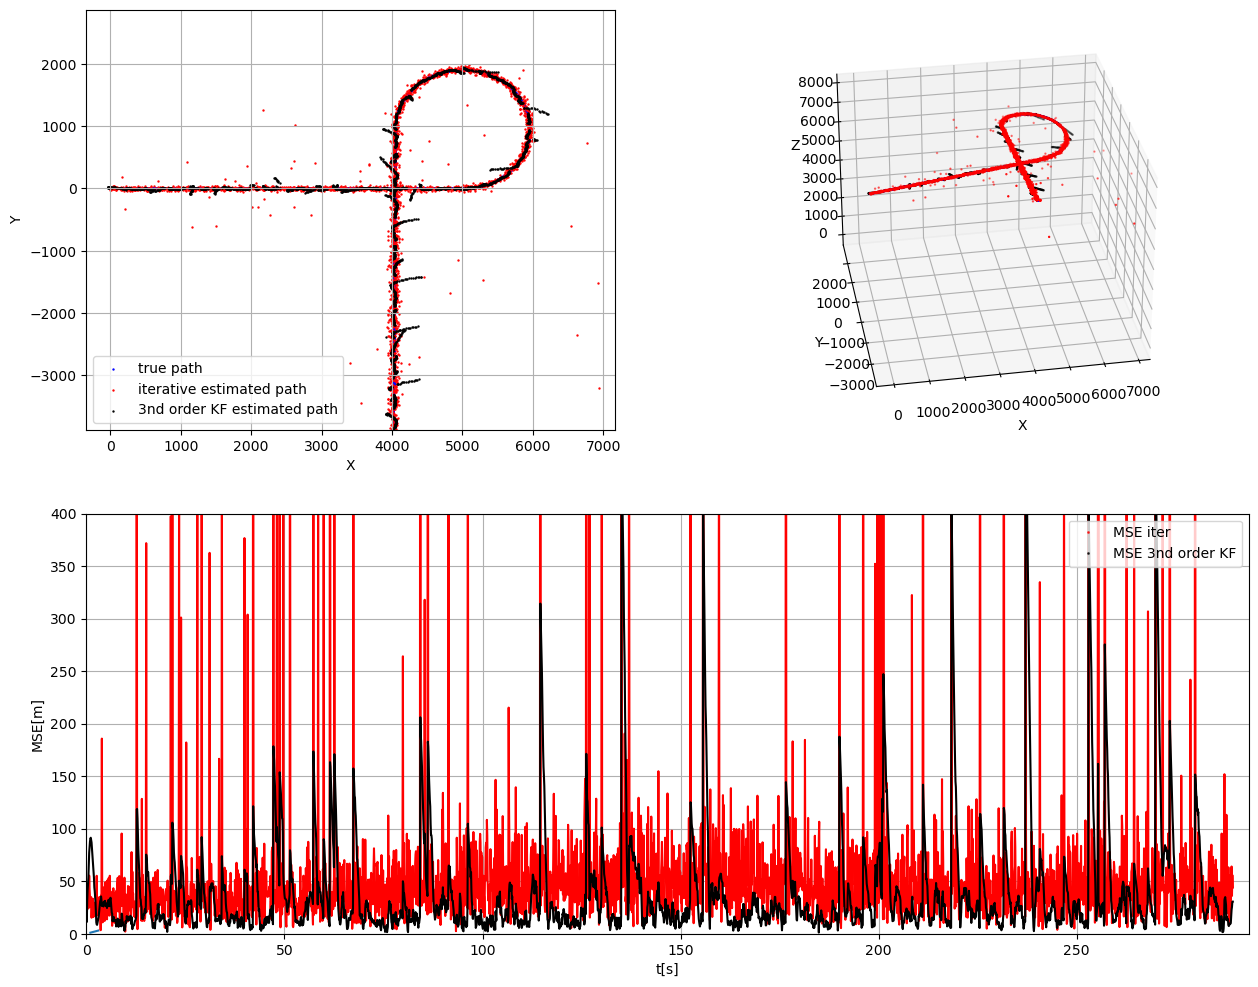

In [7]:

# animate KF with iterative with outliers (with total error)

# print the seed used
seed = np.random.randint(0, 100000)
print(seed)
np.random.seed(seed)

target_initial_pos = np.array([0, 0, 5000])
target_speed_xy = 50
target_speed_z = 10
target_rot_speed = 3
time_res = 0.1
sensor_sigma = 15
outlier_percentage = 2
outlier_sigma=500

path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
path1.add_straight_interval(100)
path1.add_xy_turn_interval(90, -np.deg2rad(target_rot_speed))
path1.add_straight_interval(100)

# create sensors
sensors = distance_sensors([[-5000,0,0], [400, -7400, 0], [800, 800, 0]], sensor_sigma, outlier_percentage=outlier_percentage, outlier_sigma=outlier_sigma)
sensors.calculate_measurements(path1.path)

# create it estimation
it_est = iterative_estimator(sensors, path1.path[0,:])
estimated_path_it = it_est.estimate_path()

sigma_a = 1
sigma_v = 100
kf_third = kalman_filter_from_points_acc(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2, initial_P_multiplier=10000)
kf_third_path = kf_third.filter_path(estimated_path_it)

# calculate estimation error
MSE_it_est = np.sqrt(np.sum(np.square(estimated_path_it-path1.path), 1))
MSE_kf_third = np.sqrt(np.sum(np.square(kf_third_path-path1.path), 1))

# Plot the estimated paths
fig = plt.figure(figsize = (15, 12))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 1, 2)

# ax1.view_init(elev=90, azim=-90)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
# ax1.set_zlabel('Z')
ax2.view_init(elev=30, azim=-100)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax1.set_xlim(-341.16209341853965, 7164.403961789332)
ax1.set_ylim(-3870.74314449314, 2867.922888909878)
# ax1.set_zlim(-392.9692483566776, 8252.35421549023)
ax2.set_xlim(-341.16209341853965, 7164.403961789332)
ax2.set_ylim(-3870.74314449314, 2867.922888909878)
ax2.set_zlim(-392.9692483566776, 8252.35421549023)


l1_1 = ax1.scatter([], [], color='blue', s=0.5, label=f'true path')
l1_2 = ax1.scatter([], [], color='red', s=0.5, label=f'iterative estimated path')
l1_3 = ax1.scatter([], [], color='red', s=0.5)
l1_4 = ax1.scatter([], [], color='k', s=0.5, label=f'3nd order KF estimated path')
ax1.legend(loc='lower left')
ax1.grid()

l2_1 = ax2.scatter([], [], [], color='blue', s=0.5)
l2_2 = ax2.scatter([], [], [], color='red', s=0.5)
l2_3 = ax2.scatter([], [], [], color='red', s=0.5)
l2_4 = ax2.scatter([], [], [], color='k', s=0.5)

l3_1 = ax3.plot([], [], label=f'MSE iter', marker='o', linestyle='', markersize=1, color='r', alpha=0.7)
l3_3 = ax3.plot([], [], label=f'MSE 3nd order KF', marker='o', linestyle='', markersize=1, color='k', alpha=0.7)

ax3.set_xlabel('t[s]')
ax3.set_ylabel('MSE[m]')
ax3.grid()
ax3.legend(loc='upper right')
ax3.set_xlim(0, 293.475)
ax3.set_ylim(0, 400)

ax3.plot([1,2,3], [1,2,3])

metadata = dict(title='KF with outliers estimator', artist='a')
writer = PillowWriter(fps=30)

with writer.saving(fig, "animations/kf_with_outliers.gif", 200):

    t = path1.time

    for i in range(0, len(t), 5):

        l1_1.remove(); l1_1 = ax1.scatter(path1.path[:i, 0], path1.path[:i, 1], color='blue', s=0.5, label=f'true path')
        l1_2.remove(); l1_2 = ax1.scatter(estimated_path_it[:i, 0], estimated_path_it[:i, 1], color='red', s=0.5, label=f'iterative estimated path')
        l1_3.remove(); l1_3 = ax1.scatter([estimated_path_it[i, 0]], [estimated_path_it[i, 1]], marker='*', linestyle='', s=3, color='red')
        l1_4.remove(); l1_4 = ax1.scatter(kf_third_path[:i, 0], kf_third_path[:i, 1], color='k', s=0.5, label=f'3nd order KF estimated path')
        l2_1.remove(); l2_1 = ax2.scatter(path1.path[:i, 0], path1.path[:i, 1], path1.path[:i, 2], color='blue', s=0.5)
        l2_2.remove(); l2_2 = ax2.scatter(estimated_path_it[:i, 0], estimated_path_it[:i, 1], estimated_path_it[:i, 2], color='red', s=0.5)
        l2_3.remove(); l2_3 = ax2.scatter([estimated_path_it[i, 0]], [estimated_path_it[i, 1]], [estimated_path_it[i, 2]], marker='*', linestyle='', s=3, color='red')
        l2_4.remove(); l2_4 = ax2.scatter(kf_third_path[:i, 0], kf_third_path[:i, 1], kf_third_path[:i, 2], color='k', s=0.5)


        l3_1[0].remove(); l3_1 = ax3.plot(t[:i], MSE_it_est[:i], label=f'MSE iter', color='r')
        l3_3[0].remove(); l3_3 = ax3.plot(t[:i], MSE_kf_third[:i], label=f'MSE 3nd order KF', color='k')

        writer.grab_frame()

# print(f"{ax1.get_xlim()=}")
# print(f"{ax1.get_ylim()=}")
# print(f"{ax1.get_zlim()=}")

# print(f"{ax2.get_xlim()=}")
# print(f"{ax2.get_ylim()=}")
# print(f"{ax2.get_zlim()=}")
        
# print(f"{ax3.get_xlim()=}")
# print(f"{ax3.get_ylim()=}")

8232


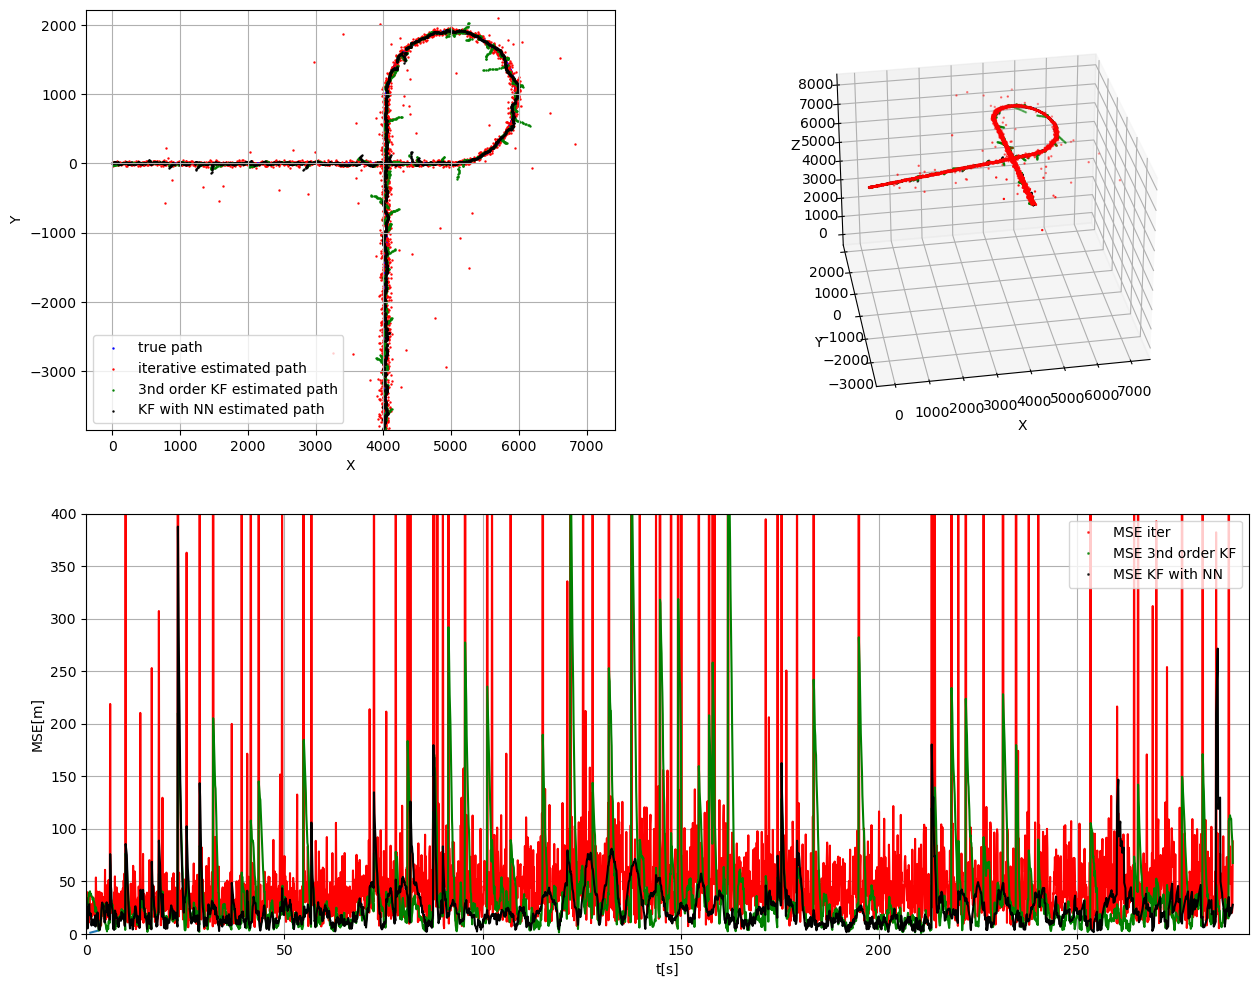

In [8]:

# animate KF with NN with outliers marked as removed (with total error)

# print the seed used
seed = 8232 #np.random.randint(0, 100000)
print(seed)
np.random.seed(seed)

target_initial_pos = np.array([0, 0, 5000])
target_speed_xy = 50
target_speed_z = 10
target_rot_speed = 3
time_res = 0.1
sensor_sigma = 15
outlier_percentage = 2
outlier_sigma=500

path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
path1.add_straight_interval(100)
path1.add_xy_turn_interval(90, -np.deg2rad(target_rot_speed))
path1.add_straight_interval(100)

# create sensors
sensors = distance_sensors([[-5000,0,0], [400, -7400, 0], [800, 800, 0]], sensor_sigma, outlier_percentage=outlier_percentage, outlier_sigma=outlier_sigma)
sensors.calculate_measurements(path1.path)

# create it estimation
it_est = iterative_estimator(sensors, path1.path[0,:])
estimated_path_it = it_est.estimate_path()

sigma_a = 1
sigma_v = 100
kf_third = kalman_filter_from_points_acc(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2, initial_P_multiplier=10000)
kf_third_path = kf_third.filter_path(estimated_path_it)

kf_NN = improved_kalman_filter_from_points_acc(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2, initial_P_multiplier=10000)
cov_mat_it = it_est.get_cov_err_with_sigma(estimated_path_it, sigma=15)
kf_NN_path = kf_NN.filter_path(estimated_path_it, cov=cov_mat_it)

# calculate estimation error
MSE_it_est = np.sqrt(np.sum(np.square(estimated_path_it-path1.path), 1))
MSE_kf_third = np.sqrt(np.sum(np.square(kf_third_path-path1.path), 1))
MSE_kf_NN = np.sqrt(np.sum(np.square(kf_NN_path-path1.path), 1))

# Plot the estimated paths
fig = plt.figure(figsize = (15, 12))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 1, 2)

# ax1.view_init(elev=90, azim=-90)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
# ax1.set_zlabel('Z')
ax2.view_init(elev=30, azim=-100)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax1.set_xlim(-383.14652119793493, 7414.8015500887905)
ax1.set_ylim(-3845.1901675885438, 2216.721591028083)
# ax1.set_zlim(-398.8734197983364, 8376.341815765063)
ax2.set_xlim(-383.14652119793493, 7414.8015500887905)
ax2.set_ylim(-3845.1901675885438, 2216.721591028083)
ax2.set_zlim(-398.8734197983364, 8376.341815765063)



l1_1 = ax1.scatter([], [], color='blue', s=0.5, label=f'true path')
l1_2 = ax1.scatter([], [], color='red', s=0.5, label=f'iterative estimated path')
l1_3 = ax1.scatter([], [], color='red', s=0.5)
l1_4 = ax1.scatter([], [], color='g', s=0.5, label=f'3nd order KF estimated path')
l1_5 = ax1.scatter([], [], color='k', s=0.5, label=f'KF with NN estimated path')
ax1.legend(loc='lower left')
ax1.grid()

l2_1 = ax2.scatter([], [], [], color='blue', s=0.5)
l2_2 = ax2.scatter([], [], [], color='red', s=0.5)
l2_3 = ax2.scatter([], [], [], color='red', s=0.5)
l2_4 = ax2.scatter([], [], [], color='g', s=0.5)
l2_5 = ax2.scatter([], [], [], color='k', s=0.5)

l3_1 = ax3.plot([], [], label=f'MSE iter', marker='o', linestyle='', markersize=1, color='r', alpha=0.7)
l3_3 = ax3.plot([], [], label=f'MSE 3nd order KF', marker='o', linestyle='', markersize=1, color='g', alpha=0.7)
l3_4 = ax3.plot([], [], label=f'MSE KF with NN', marker='o', linestyle='', markersize=1, color='k', alpha=0.7)

ax3.set_xlabel('t[s]')
ax3.set_ylabel('MSE[m]')
ax3.grid()
ax3.legend(loc='upper right')
ax3.set_xlim(0, 293.475)
ax3.set_ylim(0, 400)

ax3.plot([1,2,3], [1,2,3])

metadata = dict(title='KF and NN with outliers estimator', artist='a')
writer = PillowWriter(fps=30)

with writer.saving(fig, "animations/kf_and_NN_with_outliers.gif", 200):

    t = path1.time

    for i in range(0, len(t), 5):

        l1_1.remove(); l1_1 = ax1.scatter(path1.path[:i, 0], path1.path[:i, 1], color='blue', s=0.5, label=f'true path')
        l1_2.remove(); l1_2 = ax1.scatter(estimated_path_it[:i, 0], estimated_path_it[:i, 1], color='red', s=0.5, label=f'iterative estimated path')
        l1_3.remove(); l1_3 = ax1.scatter([estimated_path_it[i, 0]], [estimated_path_it[i, 1]], marker='*', linestyle='', s=3, color='red')
        l1_4.remove(); l1_4 = ax1.scatter(kf_third_path[:i, 0], kf_third_path[:i, 1], color='g', s=0.5, label=f'3nd order KF estimated path')
        l1_5.remove(); l1_5 = ax1.scatter(kf_NN_path[:i, 0], kf_NN_path[:i, 1], color='k', s=0.5, label=f'KF with NN estimated path')
        l2_1.remove(); l2_1 = ax2.scatter(path1.path[:i, 0], path1.path[:i, 1], path1.path[:i, 2], color='blue', s=0.5)
        l2_2.remove(); l2_2 = ax2.scatter(estimated_path_it[:i, 0], estimated_path_it[:i, 1], estimated_path_it[:i, 2], color='red', s=0.5)
        l2_3.remove(); l2_3 = ax2.scatter([estimated_path_it[i, 0]], [estimated_path_it[i, 1]], [estimated_path_it[i, 2]], marker='*', linestyle='', s=3, color='red')
        l2_4.remove(); l2_4 = ax2.scatter(kf_third_path[:i, 0], kf_third_path[:i, 1], kf_third_path[:i, 2], color='g', s=0.5)
        l2_5.remove(); l2_5 = ax2.scatter(kf_NN_path[:i, 0], kf_NN_path[:i, 1], kf_NN_path[:i, 2], color='k', s=0.5)


        l3_1[0].remove(); l3_1 = ax3.plot(t[:i], MSE_it_est[:i], label=f'MSE iter', color='r')
        l3_3[0].remove(); l3_3 = ax3.plot(t[:i], MSE_kf_third[:i], label=f'MSE 3nd order KF', color='g')
        l3_4[0].remove(); l3_4 = ax3.plot(t[:i], MSE_kf_NN[:i], label=f'MSE KF with NN', color='k')

        writer.grab_frame()

# print(f"{ax1.get_xlim()=}")
# print(f"{ax1.get_ylim()=}")
# print(f"{ax1.get_zlim()=}")

# print(f"{ax2.get_xlim()=}")
# print(f"{ax2.get_ylim()=}")
# print(f"{ax2.get_zlim()=}")
        
# print(f"{ax3.get_xlim()=}")
# print(f"{ax3.get_ylim()=}")

8232


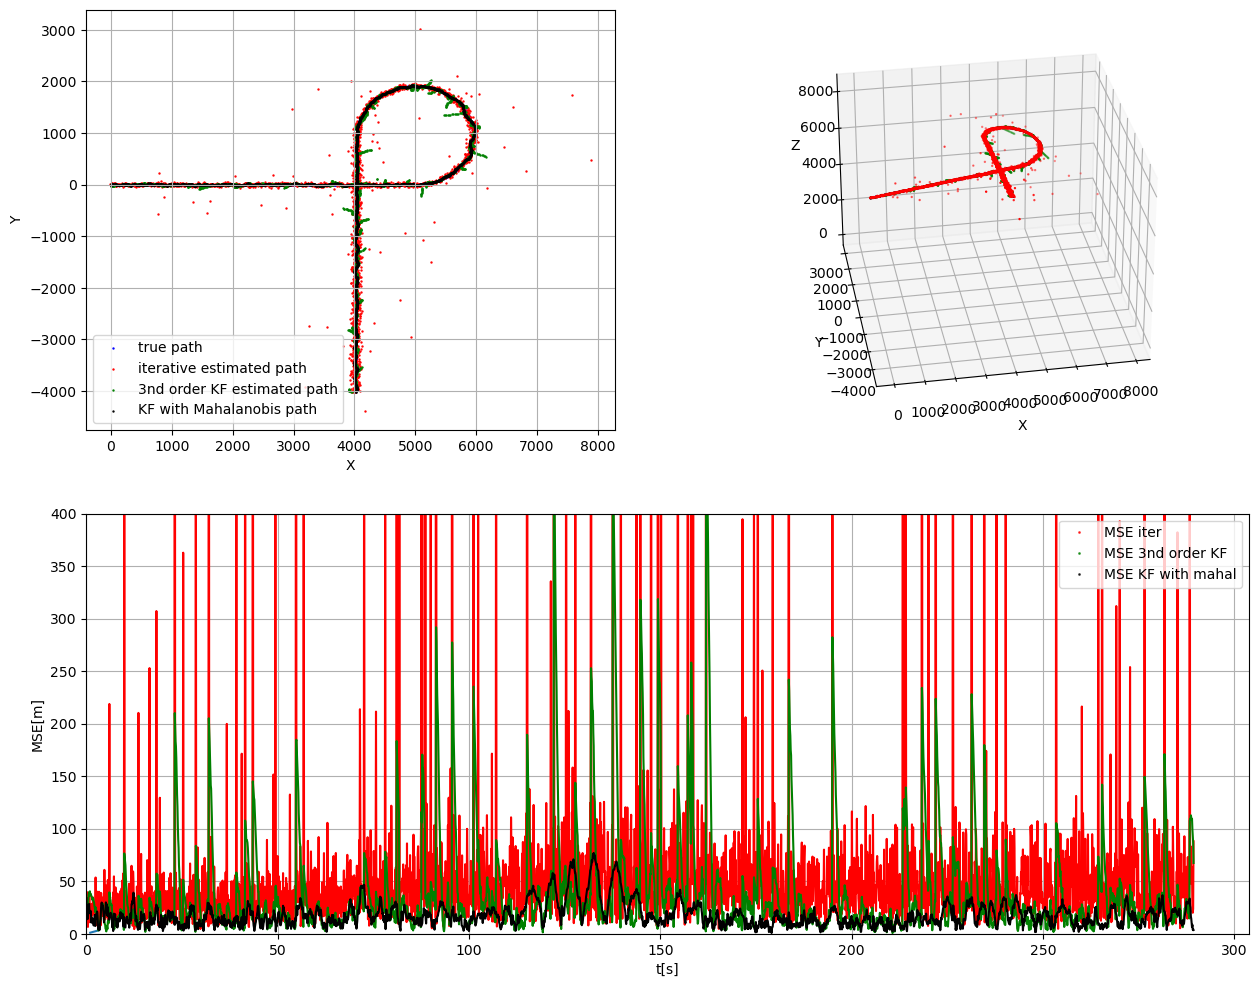

In [9]:
# animate KF with Mahalanobis with outliers marked as removed (with total error)

# print the seed used
seed = 8232 #np.random.randint(0, 100000)
print(seed)
np.random.seed(seed)

target_initial_pos = np.array([0, 0, 5000])
target_speed_xy = 50
target_speed_z = 10
target_rot_speed = 3
time_res = 0.1
sensor_sigma = 15
outlier_percentage = 2
outlier_sigma=500

path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
path1.add_straight_interval(100)
path1.add_xy_turn_interval(90, -np.deg2rad(target_rot_speed))
path1.add_straight_interval(100)

# create sensors
sensors = distance_sensors([[-5000,0,0], [400, -7400, 0], [800, 800, 0]], sensor_sigma, outlier_percentage=outlier_percentage, outlier_sigma=outlier_sigma)
sensors.calculate_measurements(path1.path)

# create it estimation
it_est = iterative_estimator(sensors, path1.path[0,:])
estimated_path_it = it_est.estimate_path()

sigma_a = 1
sigma_v = 100
kf_third = kalman_filter_from_points_acc(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2, initial_P_multiplier=10000)
kf_third_path = kf_third.filter_path(estimated_path_it)

kf_mahal = kalman_filter_with_mahalanobis(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2, initial_P_multiplier=10000)
cov_mat_it = it_est.get_cov_err_with_sigma(estimated_path_it, sigma=15)
kf_mahal_path, _, _ = kf_mahal.filter_path(estimated_path_it, cov=cov_mat_it)

# calculate estimation error
MSE_it_est = np.sqrt(np.sum(np.square(estimated_path_it-path1.path), 1))
MSE_kf_third = np.sqrt(np.sum(np.square(kf_third_path-path1.path), 1))
MSE_kf_mahal = np.sqrt(np.sum(np.square(kf_mahal_path-path1.path), 1))

# Plot the estimated paths
fig = plt.figure(figsize = (15, 12))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 1, 2)

# ax1.view_init(elev=90, azim=-90)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
# ax1.set_zlabel('Z')
ax2.view_init(elev=30, azim=-100)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax1.set_xlim(-403.760680497163, 8279.976947776044)
ax1.set_ylim(-4752.934804227216, 3391.167667918)
# ax1.set_zlim(-416.4498693462263, 8745.447256270752)
ax2.set_xlim(-403.760680497163, 8279.976947776044)
ax2.set_ylim(-4752.934804227216, 3391.167667918)
ax2.set_zlim(-416.4498693462263, 8745.447256270752)


l1_1 = ax1.scatter([], [], color='blue', s=0.5, label=f'true path')
l1_2 = ax1.scatter([], [], color='red', s=0.5, label=f'iterative estimated path')
l1_3 = ax1.scatter([], [], color='red', s=0.5)
l1_4 = ax1.scatter([], [], color='g', s=0.5, label=f'3nd order KF estimated path')
l1_5 = ax1.scatter([], [], color='k', s=0.5, label=f'KF with Mahalanobis path')
ax1.legend(loc='lower left')
ax1.grid()

l2_1 = ax2.scatter([], [], [], color='blue', s=0.5)
l2_2 = ax2.scatter([], [], [], color='red', s=0.5)
l2_3 = ax2.scatter([], [], [], color='red', s=0.5)
l2_4 = ax2.scatter([], [], [], color='g', s=0.5)
l2_5 = ax2.scatter([], [], [], color='k', s=0.5)

l3_1 = ax3.plot([], [], label=f'MSE iter', marker='o', linestyle='', markersize=1, color='r', alpha=0.7)
l3_3 = ax3.plot([], [], label=f'MSE 3nd order KF', marker='o', linestyle='', markersize=1, color='g', alpha=0.7)
l3_4 = ax3.plot([], [], label=f'MSE KF with mahal', marker='o', linestyle='', markersize=1, color='k', alpha=0.7)

ax3.set_xlabel('t[s]')
ax3.set_ylabel('MSE[m]')
ax3.grid()
ax3.legend(loc='upper right')
ax3.set_xlim(0, 303.86999999999716)
ax3.set_ylim(0, 400)

ax3.plot([1,2,3], [1,2,3])

metadata = dict(title='KF and Mahal with outliers estimator', artist='a')
writer = PillowWriter(fps=30)

with writer.saving(fig, "animations/kf_and_Mahal_with_outliers.gif", 200):

    t = path1.time

    for i in range(0, len(t), 5):

        l1_1.remove(); l1_1 = ax1.scatter(path1.path[:i, 0], path1.path[:i, 1], color='blue', s=0.5, label=f'true path')
        l1_2.remove(); l1_2 = ax1.scatter(estimated_path_it[:i, 0], estimated_path_it[:i, 1], color='red', s=0.5, label=f'iterative estimated path')
        l1_3.remove(); l1_3 = ax1.scatter([estimated_path_it[i, 0]], [estimated_path_it[i, 1]], marker='*', linestyle='', s=3, color='red')
        l1_4.remove(); l1_4 = ax1.scatter(kf_third_path[:i, 0], kf_third_path[:i, 1], color='g', s=0.5, label=f'3nd order KF estimated path')
        l1_5.remove(); l1_5 = ax1.scatter(kf_mahal_path[:i, 0], kf_mahal_path[:i, 1], color='k', s=0.5, label=f'KF with Mahalanobis path')
        l2_1.remove(); l2_1 = ax2.scatter(path1.path[:i, 0], path1.path[:i, 1], path1.path[:i, 2], color='blue', s=0.5)
        l2_2.remove(); l2_2 = ax2.scatter(estimated_path_it[:i, 0], estimated_path_it[:i, 1], estimated_path_it[:i, 2], color='red', s=0.5)
        l2_3.remove(); l2_3 = ax2.scatter([estimated_path_it[i, 0]], [estimated_path_it[i, 1]], [estimated_path_it[i, 2]], marker='*', linestyle='', s=3, color='red')
        l2_4.remove(); l2_4 = ax2.scatter(kf_third_path[:i, 0], kf_third_path[:i, 1], kf_third_path[:i, 2], color='g', s=0.5)
        l2_5.remove(); l2_5 = ax2.scatter(kf_mahal_path[:i, 0], kf_mahal_path[:i, 1], kf_mahal_path[:i, 2], color='k', s=0.5)


        l3_1[0].remove(); l3_1 = ax3.plot(t[:i], MSE_it_est[:i], label=f'MSE iter', color='r')
        l3_3[0].remove(); l3_3 = ax3.plot(t[:i], MSE_kf_third[:i], label=f'MSE 3nd order KF', color='g')
        l3_4[0].remove(); l3_4 = ax3.plot(t[:i], MSE_kf_mahal[:i], label=f'MSE KF with Mahalanobis', color='k')

        writer.grab_frame()

# print(f"{ax1.get_xlim()=}")
# print(f"{ax1.get_ylim()=}")
# print(f"{ax1.get_zlim()=}")

# print(f"{ax2.get_xlim()=}")
# print(f"{ax2.get_ylim()=}")
# print(f"{ax2.get_zlim()=}")
        
# print(f"{ax3.get_xlim()=}")
# print(f"{ax3.get_ylim()=}")